# An Analysis of Heart Attacks in Nigeria

### Machine Learning Portion

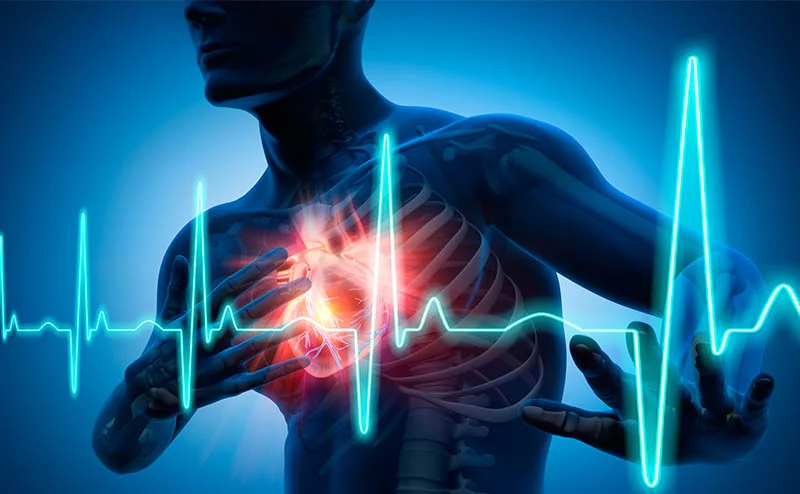

Importing everything...

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.discriminant_analysis
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTEENN
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import classification_report
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.combine import SMOTETomek
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from imblearn.ensemble import BalancedRandomForestClassifier

# Preprocessing

Let's start by reading in the dataset and cleaning up the columns.

In [26]:
nigeria = pd.read_csv('C:/Users/RCallis/Jupyter Notebook/data/heart_attack_nigeria_youth_vs_adult.csv')
print(nigeria.columns)

Index(['ID', 'Age', 'Gender', 'Region', 'Blood_Pressure', 'Cholesterol', 'BMI',
       'Heart_Rate', 'Exercise_Level', 'Smoking', 'Alcohol_Consumption',
       'Diabetes', 'Family_History', 'Stress_Level', 'Heart_Attack', 'Angina',
       'Heart_Disease_History', 'Diet', 'Sleep_Hours', 'Occupation',
       'Income_Level', 'Physical_Activity', 'Education_Level',
       'Marital_Status', 'Urban_Rural', 'Medication', 'Health_Awareness',
       'Daily_Water_Intake', 'Mental_Health', 'Obesity'],
      dtype='object')


In [27]:
nigeria.columns = (
    nigeria.columns
    .str.strip()          
    .str.lower()  
    .str.replace(' ', '_')  
    .str.replace('[^a-z0-9_]', '', regex=True)
)

print(nigeria.columns)

Index(['id', 'age', 'gender', 'region', 'blood_pressure', 'cholesterol', 'bmi',
       'heart_rate', 'exercise_level', 'smoking', 'alcohol_consumption',
       'diabetes', 'family_history', 'stress_level', 'heart_attack', 'angina',
       'heart_disease_history', 'diet', 'sleep_hours', 'occupation',
       'income_level', 'physical_activity', 'education_level',
       'marital_status', 'urban_rural', 'medication', 'health_awareness',
       'daily_water_intake', 'mental_health', 'obesity'],
      dtype='object')


Are there any null values?

In [28]:
print(nigeria.isnull().sum())

id                           0
age                          0
gender                       0
region                       0
blood_pressure               0
cholesterol                  0
bmi                          0
heart_rate                   0
exercise_level               0
smoking                      0
alcohol_consumption      35070
diabetes                     0
family_history               0
stress_level                 0
heart_attack                 0
angina                       0
heart_disease_history        0
diet                         0
sleep_hours                  0
occupation                   0
income_level                 0
physical_activity            0
education_level              0
marital_status               0
urban_rural                  0
medication                   0
health_awareness             0
daily_water_intake           0
mental_health                0
obesity                      0
dtype: int64


Only for alcohol consumption; let's fill those with 'Unknown' instead. Also, get_dummies will allow for machine learning to go smoothly.

In [29]:
nigeria.fillna('Unknown', inplace=True)

In [30]:
nigeria = pd.get_dummies(nigeria, drop_first=True)

# Choosing a Machine Learning Model

First, let's separate the features (X) and target variable (Y). Then, we'll split the dataset so 80% is used as the training set, while 20% is used as the validation set.

In [31]:
X = nigeria.drop('heart_attack', axis=1)
Y = nigeria['heart_attack']

X_train, X_validation, Y_train, Y_validation = train_test_split(
    X, Y, test_size=0.50, stratify=Y, random_state=1
)

I imagine this dataset is imbalanced, since having a heart attack is more rare than not having one. Let's check using value_counts.

In [32]:
print(Y.value_counts())

heart_attack
False    45014
True      4986
Name: count, dtype: int64


Just as expected, only ~10% of people in the dataset had a heart attack. We can implement SMOTEEN to fix this imbalance by giving more representation to the minority class. After all, it's more important to be right when it matters than to be more accurate overall.

In [33]:
smote_enn = SMOTEENN(random_state=1)
X_train_resampled, Y_train_resampled = smote_enn.fit_resample(X_train, Y_train)

print("Class distribution after resampling:")
print(pd.Series(Y_train_resampled).value_counts())

Class distribution after resampling:
heart_attack
True     19360
False    10677
Name: count, dtype: int64


Now, in the training dataset, heart-attack and non-heart-attack cases have equal representation. Let's move on to finding a model. We'll use supervised models to pinpoint the accuracy of each.

Testing model cross-validation accuracies...
Linear Discriminant Analysis: 0.884875 (0.002200)
K-Nearest Neighbors: nan (nan)


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:842: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 136, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\_response.py", line 85, in _get_response_values
    y_pred = prediction_method(X)
             ^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\

Decision Tree: 0.839065 (0.002245)
Naive Bayes: 0.874322 (0.001706)
Random Forest: 0.918867 (0.002783)
XGBoost: 0.911343 (0.001263)


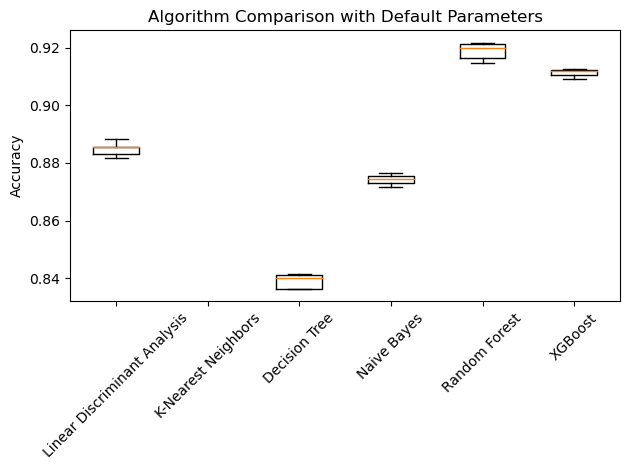

In [34]:
models = [
    ('Linear Discriminant Analysis', sklearn.discriminant_analysis.LinearDiscriminantAnalysis()),
    ('K-Nearest Neighbors', KNeighborsClassifier()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Naive Bayes', GaussianNB()),
    ('Random Forest', RandomForestClassifier()),
    ('XGBoost', xgb.XGBClassifier())
]

results = []
names = []

print("Testing model cross-validation accuracies...")

for name, model in models:
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    cv_results = cross_val_score(model, X_train_resampled, Y_train_resampled, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print(f'{name}: {cv_results.mean():.6f} ({cv_results.std():.6f})')

plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison with Default Parameters')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

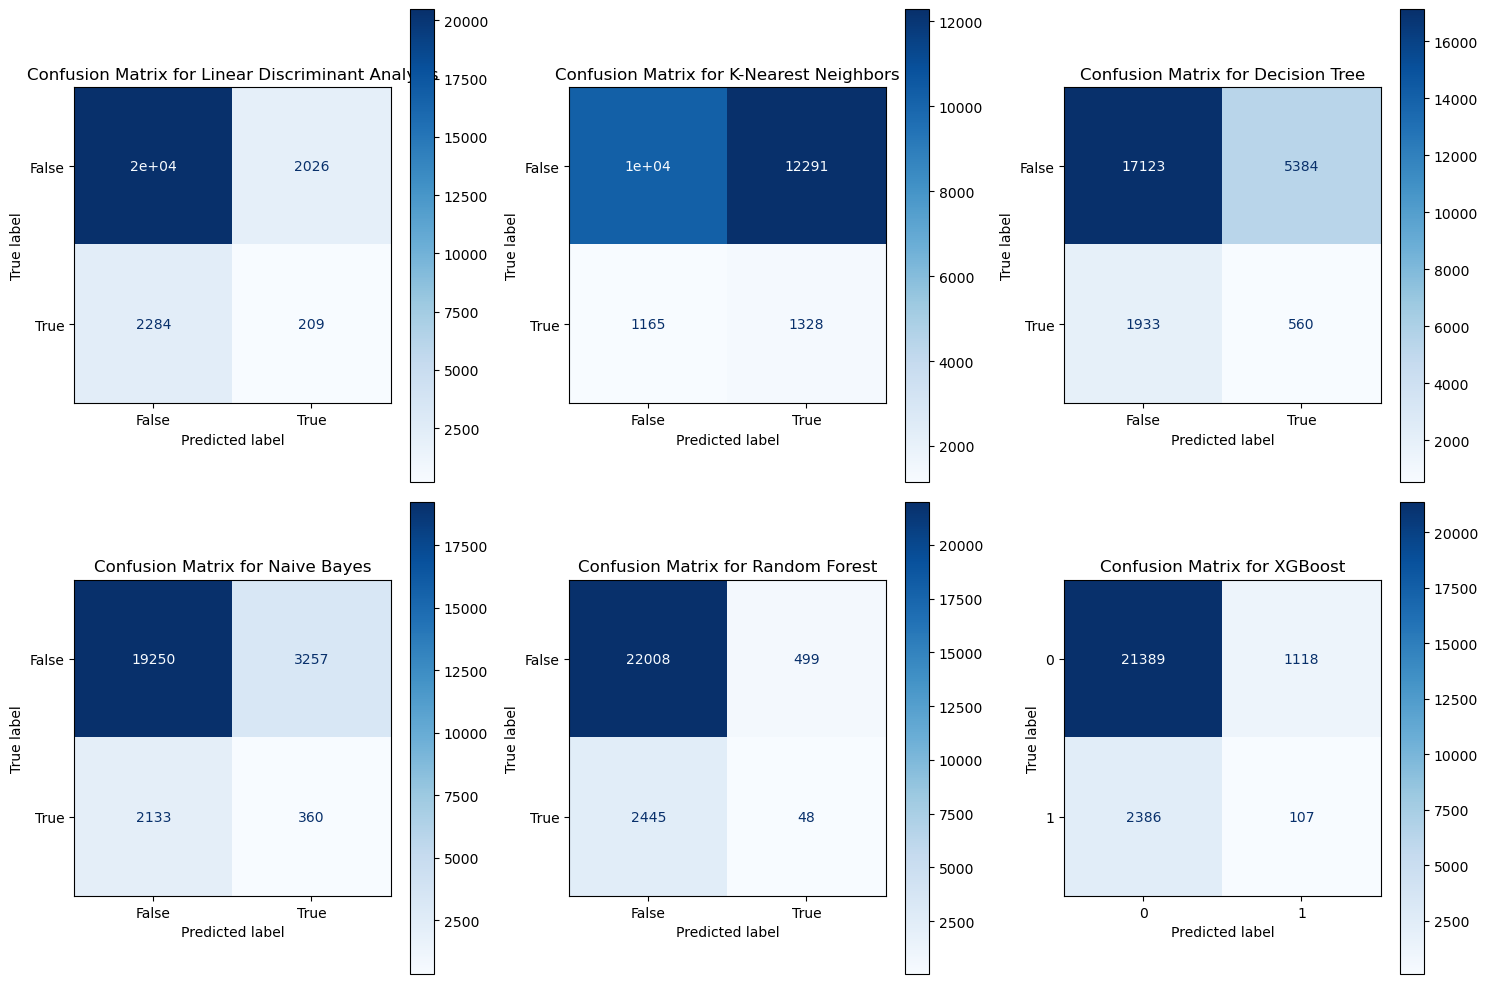

In [35]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.ravel()

for i, (name, model) in enumerate(models):
    model.fit(np.asarray(X_train_resampled), np.asarray(Y_train_resampled))
    
    Y_pred = model.predict(np.asarray(X_validation))
    
    cm = confusion_matrix(Y_validation, Y_pred)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(ax=axes[i], cmap='Blues')
    axes[i].set_title(f'Confusion Matrix for {name}')

plt.tight_layout()
plt.show()

# Hyperparameter Optimization

Random Forest already takes the longest to run out of any model, so we should limit the parameter grid to save time.

In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],         
}

rf = RandomForestClassifier(random_state=1)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=kfold, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train_resampled, Y_train_resampled)

print("Best parameters found:", grid_search.best_params_)
print(f"Best cross-validated accuracy: {grid_search.best_score_:.6f}")

best_rf = grid_search.best_estimator_
Y_pred = best_rf.predict(X_validation)
test_accuracy = accuracy_score(Y_validation, Y_pred)
print(f"Test set accuracy with optimized Random Forest: {test_accuracy:.6f}")

# Confusion Matrix

This model has about 90% accuracy. In what way is it making errors 10% of the time?

In [35]:
'''
lda2 = sklearn.discriminant_analysis.LinearDiscriminantAnalysis()
lda2.fit(X_train, Y_train)

Y_pred = lda2.predict(X_validation)

cm = confusion_matrix(Y_validation, Y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lda2.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for LDA Model')
plt.show()
'''

"\nlda2 = sklearn.discriminant_analysis.LinearDiscriminantAnalysis()\nlda2.fit(X_train, Y_train)\n\nY_pred = lda2.predict(X_validation)\n\ncm = confusion_matrix(Y_validation, Y_pred)\n\ndisp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lda2.classes_)\ndisp.plot(cmap='Blues')\nplt.title('Confusion Matrix for LDA Model')\nplt.show()\n"